In [1]:
import numpy as np
import pandas as pd
import wave
import math



In [2]:
# Matplotlib stuff 

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [18, 12]
mpl.rcParams['figure.dpi'] = 72

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
mpl.rcParams.update(params)


import matplotlib.pyplot as plt

In [3]:
file_path = "./data/DoubleBlinkLR_Alex"

obj = wave.open(f'{file_path}.wav')
print(obj)

# Sample rate (looks to be 10k samples/sec) from brainbox
print(f"Sample rate: {obj.getframerate()} samples/sec")

# Bytes per sample
print(f"Sample size: {obj.getsampwidth()} bytes")

# Bytes per sample
print(f"No. channels: {obj.getnchannels()}")

print(obj.getparams())



wav_frames = obj.readframes(nframes=2**32)
ys = np.frombuffer(wav_frames, dtype=np.int16)
print(len(ys))
print(ys)


sample_df = pd.DataFrame({
    "sample": ys,
    "time_sec": np.arange(len(ys)) / obj.getframerate(),
})
print(sample_df[:20])


Sample rate: 10000 samples/sec
Sample size: 2 bytes
No. channels: 1
_wave_params(nchannels=1, sampwidth=2, framerate=10000, nframes=1878295, comptype='NONE', compname='not compressed')
1878295
[-113 -116 -119 ...  126  122  118]
    sample  time_sec
0     -113    0.0000
1     -116    0.0001
2     -119    0.0002
3     -122    0.0003
4     -124    0.0004
5     -126    0.0005
6     -129    0.0006
7     -132    0.0007
8     -134    0.0008
9     -137    0.0009
10    -138    0.0010
11    -141    0.0011
12    -143    0.0012
13    -145    0.0013
14    -148    0.0014
15    -149    0.0015
16    -151    0.0016
17    -153    0.0017
18    -155    0.0018
19    -157    0.0019


In [4]:


events_df = pd.read_csv(
    f"{file_path}.txt",
    names=["event_id", "time_sec"],
    header=1
)

events_df["event_type"] = events_df["event_id"].map({
    0: "Blink",
    1: "Left",
    2: "Right"
})

events_df["event_color"] = events_df["event_type"].map({
    "Blink": "red",
    "Left": "green",
    "Right": "blue"
})

print(events_df)



    event_id  time_sec event_type event_color
0          1    9.9953       Left       green
1          1   14.0867       Left       green
2          2   16.7407      Right        blue
3          2   19.5746      Right        blue
4          1   22.6953       Left       green
..       ...       ...        ...         ...
70         2  173.2866      Right        blue
71         2  175.1507      Right        blue
72         2  177.2419      Right        blue
73         1  179.2657       Left       green
74         2  181.4798      Right        blue

[75 rows x 4 columns]


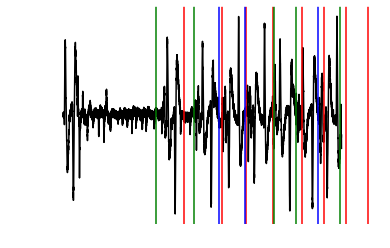

In [5]:
time_start = 0
time_end = 30

sample_df_int = sample_df[(sample_df["time_sec"] >= time_start) & (sample_df["time_sec"] < time_end)]
events_df_int = events_df[(events_df["time_sec"] >= time_start) & (events_df["time_sec"] < time_end)]

plt.plot(
    sample_df_int["time_sec"],
    sample_df_int["sample"],
    color="black"
)

for idx,row in events_df_int.iterrows():
    plt.axvline(
        x = row["time_sec"],
        color=row["event_color"]
    )
    plt.axvline(
        x = row["time_sec"]+3,
        color="red"
    )

plt.show()

# Classify

Classify 3-second intervals.

Makes sure you give it a bunch of 3-sec intervals which are NOT valid.
I guess one method is to classify every moment as inside or outside an event. Like the start of every 3 second interval has a 500ms (1000ms?) interval where it should output the correct event type for the next 3 seconds. If not in an event type, it should output "None" or whatever.

Stuff like involuntary blinks should be ignored.


3s interval gives 30000 input samples.
60 seconds gives 600000 inputs.

I guess you could probs downsample via moving average and everything would be the same?
Maybe 1/100th of a second VS 1/10000th? Gives 6000 inputs of size 300.


Accuracy is then instead based on the full stream and not individual samples. Since the 499th should really be the same as the 500th, but thats not really feasible.
Maybe then you could have the output be gaussian around the point of classification? Like the exact moment should output 100%, but slowly decrease as you move away.



       time_sec       sample
0          0.00  -105.980000
1          0.01   129.440000
2          0.02   -33.440000
3          0.03   116.550000
4          0.04  -125.850000
...         ...          ...
18778    187.78 -1222.540000
18779    187.79 -1108.520000
18780    187.80  -457.560000
18781    187.81  -466.170000
18782    187.82    57.021053

[18783 rows x 2 columns]


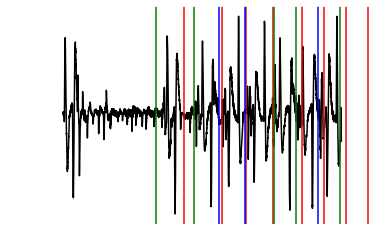

In [7]:

def downsample(sample_df, n=100):
    """ Downsamples to 1/nth of a second by taking mean sample over that period. """
    # Downsample to 1/100th of a second 
    time_sec_n = np.floor(n*sample_df["time_sec"]) / n

    sample_n_df = pd.DataFrame({
        "time_sec": list(sample_df.groupby(time_sec_n)["time_sec"].min()),
        "sample": list(sample_df.groupby(time_sec_n)["sample"].mean()),
    })

    return sample_n_df



sample_100_df = downsample(sample_df, n=100)
print(sample_100_df)


time_start = 0
time_end = 30

sample_df_int = sample_100_df[(sample_100_df["time_sec"] >= time_start) & (sample_100_df["time_sec"] < time_end)]
events_df_int = events_df[(events_df["time_sec"] >= time_start) & (events_df["time_sec"] < time_end)]

plt.plot(
    sample_df_int["time_sec"],
    sample_df_int["sample"],
    color="black"
)

for idx,row in events_df_int.iterrows():
    plt.axvline(
        x = row["time_sec"],
        color=row["event_color"]
    )
    plt.axvline(
        x = row["time_sec"]+3,
        color="red"
    )

plt.show()



       time_sec       sample event_type
0          0.00  -105.980000       None
1          0.01   129.440000       None
2          0.02   -33.440000       None
3          0.03   116.550000       None
4          0.04  -125.850000       None
...         ...          ...        ...
18778    187.78 -1222.540000       None
18779    187.79 -1108.520000       None
18780    187.80  -457.560000       None
18781    187.81  -466.170000       None
18782    187.82    57.021053       None

[18783 rows x 3 columns]


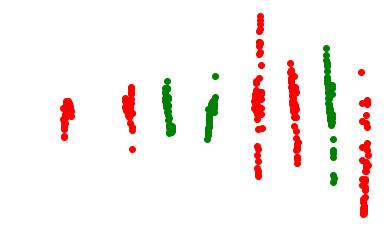

In [8]:
# Add target classification event to each sample

sample_100_df = downsample(sample_df, n=100)
sample_100_df["event_type"] = None
#print(sample_100_df)


event_time_interval = 0.5 # The time interval around an event marker which should be classified as that event
for idx,row in events_df_int.iterrows():
    # Skip blinks for now
    if row["event_type"] not in ["Left", "Right"]:
        continue

    event_interval = (sample_100_df["time_sec"] > (row["time_sec"] - event_time_interval/2))
    event_interval &= (sample_100_df["time_sec"] < (row["time_sec"] + event_time_interval/2))
    
    sample_100_df.loc[event_interval,"event_type"] = row["event_type"]

print(sample_100_df)



time_start = 0
time_end = 30

sample_df_int = sample_100_df[(sample_100_df["time_sec"] >= time_start) & (sample_100_df["time_sec"] < time_end)]

for name, group in sample_df_int.groupby("event_type"):
    plt.scatter(
        group["time_sec"],
        group["sample"],
        color={
            None: "blue",
            "Right": "green",
            "Left": "red"
        }[name]
    )

plt.show()


